# Sequence generation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import torch
import umap
from evoamp.models import EvoAMP
import numpy as np

torch.manual_seed(0);

In [2]:
def prettify(sequence: list[list[str]]) -> list[str]:
    return "".join(sequence)

In [19]:
def plot_umap(embedding: list[np.ndarray], group: pd.Series) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=(4, 3))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=group, cmap="viridis", s=4)
    ax.legend(*scatter.legend_elements(), title=group.name)
    ax.set_aspect("equal", "datalim")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax

With the pretrained model, let's generate a few sequences.

In [4]:
DATA_PATH = "../data/processed/amp_8_35.csv"
MODEL_PATH = "../outputs/2024-05-19/21-25-46/pretrained_model"

In [5]:
model = EvoAMP.load(MODEL_PATH)

In [6]:
df = pd.read_csv(DATA_PATH)

Generate new sequences (unconditioned).

In [7]:
sequences = model.sample(n_samples=200, is_amp=1, reference_sequence=None)
sequence_lengths = [len(seq) for seq in sequences]
sequences = [prettify(seq) for seq in sequences]

In [8]:
sequences[:10]

['RKIEDESEAI',
 'RLQNLFGISIHMDCLDLIPARQHV',
 'RYELLTALNGCTVGFCCCKKKKCCC',
 'RDNKDCQLHAPHV',
 'RMKYSFALVGAKPLPKFSRK',
 'RHRHIPTICNMICGATGAISGKC',
 'RKIQEMDESCVISPNTNTGTTLLSVVGGGGGTGGN',
 'RLLNSDTVCNEGAGEAVEAAAV',
 'RKKKPFARGAESKKK',
 'RSYPLQAQERDDKNCLFCQQICCCFIFCCC']

In [9]:
p_sequences_in_dataset = df['sequence'].isin(sequences).sum() / len(df)
print(f"Percentage of generated sequences in dataset: {p_sequences_in_dataset:.2f}%")

Percentage of generated sequences in dataset: 0.00%


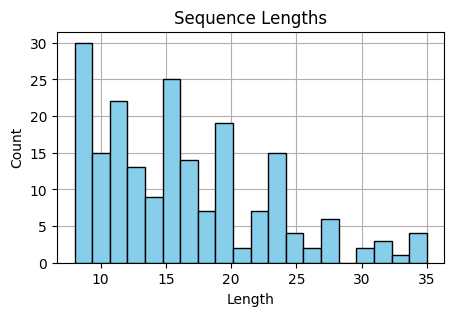

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(sequence_lengths, bins=20, color="skyblue", edgecolor="black")
ax.set_title("Sequence Lengths")
ax.set_xlabel("Length")
ax.set_ylabel("Count")
ax.grid(True)
ax.set_axisbelow(True)

Generate new sequences based on reference sequence.

In [11]:
k = 20

reference_sequence = df.iloc[k]["sequence"]
is_amp = df.iloc[k]["is_amp"]

print(f"Reference sequence: {reference_sequence}")
print(f"Is AMP: {is_amp}")

Reference sequence: SDFVSGNEE
Is AMP: 0


In [12]:
sequences = model.sample(n_samples=200, is_amp=is_amp, reference_sequence=reference_sequence)
sequence_lengths = [len(seq) for seq in sequences]
sequences = [prettify(seq) for seq in sequences]

min_len = min(sequence_lengths)
max_len = max(sequence_lengths)
print(f"Generated sequence's lengths between {min_len} and {max_len} (reference: {len(reference_sequence)})")

Generated sequence's lengths between 9 and 9 (reference: 9)


In [13]:
p_sequences_in_dataset = df['sequence'].isin(sequences).sum() / len(df)
print(f"Percentage of generated sequences in dataset: {p_sequences_in_dataset:.2f}%")

Percentage of generated sequences in dataset: 0.00%


Let's look at the latent representation.

In [14]:
k = 1_000
df_subset = df.iloc[:k].copy()
df_subset["sampled"] = False

df_sampled = pd.DataFrame({"sequence": sequences, "is_amp": is_amp, "sampled": True})
df_subset = pd.concat([df_subset, df_sampled])

In [15]:
latent_reps = [
    model.get_latent_representation(seq, is_amp) for seq, is_amp in zip(df_subset["sequence"], df_subset["is_amp"])
]

In [16]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_reps)

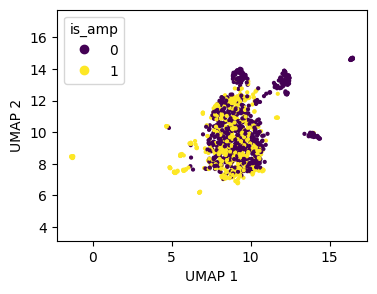

In [20]:
plot_umap(embedding, df_subset["is_amp"]);

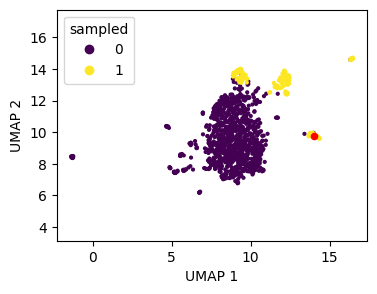

In [25]:
fig, ax = plot_umap(embedding, df_subset["sampled"])
ax.scatter(embedding[k, 0], embedding[k, 1], c="red", label="Reference sequence", s=20);